# Gender Classification
<p>Train and Evaluate multiple CNN architecture for Gender Classification</p>
<p>Dataset is subset of CelebA with 5K images that can be downloaded from <a href="https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB">Google Drive</a>. The notebook is configured to download the dataset automatically without any manual copy-paste required</p>

# Import Libraries
<p>
    You might need to install the libraries separately with below commands if import library is not successful:
    <li>pip install pandas</li>
    <li>pip install scikit-learn</li>
    <li>pip install torch</li>
    <li>pip install torchvision</li>
    <li>pip install Pillow</li>
    <li>pip install matplotlib</li>
    <li>pip install imagehash</li>
</p>

In [1]:
!pip install imagehash

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import imagehash
import time
from torch.autograd import Variable

# Data Preparation

In [3]:
# setup default folders for storing dataset, model state and reports
# modify this line according to your Notebook Environment
data_path='./Dataset/Dataset5K' # dataset
model_path='./Models' # model state
eval_path='./Evaluation/Training' # training evaluation report
os.makedirs(model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## Download Dataset
This cell is optional and can be skipped if the dataset is already available in data_path
You might need to install gdown library with command: <b>pip install gdown</> to run this cell below

In [4]:
import gdown
import zipfile
# File URL
file_url = "https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB"

# Output file name
output = "./Dataset/Dataset5K.zip"

if not os.path.exists(output):
    # Download the file
    gdown.download(file_url, output, quiet=False)
    print("Download completed!")

if os.path.exists(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(data_path)

Downloading...
From (original): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB
From (redirected): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB&confirm=t&uuid=59d94f87-d171-480b-983f-1f94da1e04b3
To: /content/Dataset/Dataset5K.zip
100%|██████████| 287M/287M [00:04<00:00, 65.8MB/s]


Download completed!


## EDA Dataset

In [5]:
os.listdir(data_path)

['list_attribute.txt',
 'gender_classification.xlsx',
 'class_identity.txt',
 'model_saved',
 'gender_classification.csv',
 'Images']

In [6]:
images_path = os.path.join(data_path, 'Images')
images_list = os.listdir(images_path)

In [7]:
def calculate_phash(image_path):
     """Calculates the perceptual hash of an image."""
     try:
         img = Image.open(image_path)
         hash_value = imagehash.phash(img)
         return hash_value
     except Exception as e:
         print(f"Error processing {image_path}: {e}")
         return None

def find_duplicate_images(image_folder, images_list):
     """Finds duplicate images based on their perceptual hashes."""
     hashes = {}
     duplicates = []

     for image_path in images_list:
         hash_value = calculate_phash(os.path.join(image_folder, image_path))
         if hash_value is None:
             continue

         if hash_value in hashes:
             duplicates.append((hashes[hash_value], image_path))
         else:
             hashes[hash_value] = image_path
     return duplicates

In [8]:
# load the data
data = pd.read_csv(data_path + '/list_attribute.txt', sep='\\s+', skiprows=1)
# filter the data with available images only (5000 images)
filter_index = data.index.intersection(images_list)
data = data.loc[filter_index]['Male'].reset_index().rename(columns={'index':'Filename'})
data['Male'] = np.where(data['Male'] == 1, 1, 0)
data.head()

,Filename,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0


### Check and remove file duplication

Duplicated images: 2


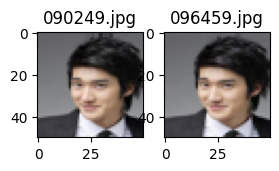

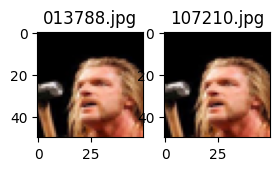

In [9]:
duplicates = find_duplicate_images(data_path + '/Images', data['Filename'])

print(f'Duplicated images: {len(duplicates)}')
# show duplicated images, take max 3 images as sample
for ix, dup_images in enumerate(duplicates):
    if ix == 3:
        break
    count = len(dup_images)
    fig, axs = plt.subplots(1, count, figsize=(1.5 * len(duplicates), 1.5))  # smaller figure

    for iy, dup_image in enumerate(dup_images):
        img = Image.open(os.path.join(images_path, dup_image)).resize((50, 50))  # very small thumbnail
        axs[iy].imshow(img)
        axs[iy].set_title(f"{dup_image}")


In [10]:
# remove duplicate images and maintain only 1 data
rem_images = []
for dup_images in duplicates:
    rem_images += dup_images[1:]
data = data[~data['Filename'].isin(rem_images)]

# validate duplication again to ensure data is clean
duplicates = find_duplicate_images(data_path + '/Images', data['Filename'])
print(f'Duplicates: {len(duplicates)}, Dataset shape: {data.shape}')

Duplicates: 0, Dataset shape: (4998, 2)


### Explore image resolution variation

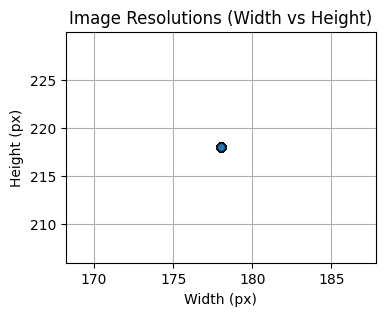

In [11]:
# Lists to hold widths and heights
widths = []
heights = []

# Iterate through image files
for filename in images_list:
    try:
        img_path = os.path.join(images_path, filename)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print(f"Error with {filename}: {e}")

# Plot width vs height
plt.figure(figsize=(4, 3))
plt.scatter(widths, heights, alpha=0.6, edgecolors='k')
plt.title("Image Resolutions (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.grid(True)
plt.show()

### Explore dataset label variation

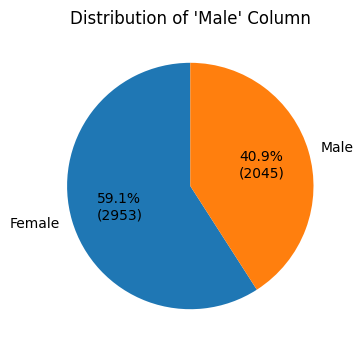

In [12]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return my_format

# Count occurrences of each unique label in 'Male' column
labels = data['Male'].map({0:'Female', 1:'Male'})
label_counts = labels.value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
label_counts.plot.pie(autopct=autopct_format(label_counts), startangle=90)
plt.title("Distribution of 'Male' Column")
plt.ylabel('')  # Hide y-label
plt.show()

### Split Train and Test data

In [13]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.shape, test_data.shape

((3998, 2), (1000, 2))

In [14]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])

        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

### Data Augmentation and Preparation

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize to match model input size
    transforms.RandomHorizontalFlip(),             # Randomly flip images horizontally
    transforms.RandomRotation(10),                 # Random rotation between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2,         # Random brightness, contrast, saturation
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                         # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

In [16]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

#### Show train data Augmentation result

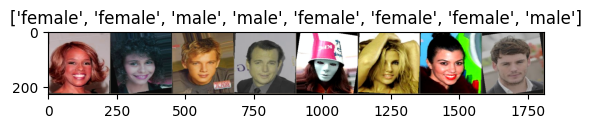

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
# limit to 8 images only
inputs = inputs[:8]
classes = classes[:8]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['female', 'male']
imshow(out, title=[class_names[x] for x in classes])

# Modeling

In [18]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, model_name, use_gpu=torch.cuda.is_available(),num_epochs=10):
    # please define the training model (VGG/GoogleNet/ResNet) here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0

    acc_histories = []
    loss_histories = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        acc_history = { 'train': 0, 'test': 0 }
        loss_history = { 'train': 0, 'test': 0 }
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for data in dataloders[phase]:
                 # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                 # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_history[phase] = round(epoch_acc.item(), 4)
            loss_history[phase] = round(epoch_loss.item(), 4)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = round(epoch_acc.item(), 4)
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state, os.path.join(model_path, model_name))
                best_epoch = epoch
                print(f'✅ Best model saved! (Accuracy: {best_acc})')
        acc_histories.append(acc_history)
        loss_histories.append(loss_history)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch

def store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_history, loss_histories):
    train_values = np.array([item['train'] for item in acc_histories])
    test_values = np.array([item['test'] for item in acc_histories])

    l_train_values = np.array([item['train'] for item in loss_histories])
    l_test_values = np.array([item['test'] for item in loss_histories])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()  # flatten 2x2 grid to list for easy indexing
    # Plot training and validation accuracy
    axs[0].plot(train_values, label='Training Accuracy')
    axs[0].plot(test_values, label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim(0.5, 1.00)
    axs[0].legend()

    # Plot training and validation loss
    axs[1].plot(l_train_values, label='Training Accuracy')
    axs[1].plot(l_test_values, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.savefig(os.path.join(eval_path, model_name + '_train_loss.png'), dpi=300)
    plt.show()

    df = pd.DataFrame({'train': train_values, 'test': test_values})
    df.to_csv(os.path.join(eval_path, model_name + '_train_acc.csv'))

    df_sum = pd.DataFrame({'model': [model_name],
                           'device': [torch.cuda.get_device_name(0)],
                           'time_elapsed' : [time_elapsed],
                           'best_epoch': [best_epoch],
                           'best_acc': [best_acc]})
    df_sum.to_csv(os.path.join(eval_path, model_name + '_train_sum.csv'))
    print(df_sum)

In [19]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

# Architectures and Model Training

In [20]:
use_gpu = torch.cuda.is_available()

In [21]:
# GoogleNet default weights
def googlenet(use_gpu):
    model = models.googlenet(aux_logits=False, init_weights=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'googlenet_5k_best.pth'
    return model, model_name

# GoogleNet pre-trained ImageNet
def googlenet_pt(use_gpu):
    weights = models.GoogLeNet_Weights.DEFAULT
    model = models.googlenet(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'googlenet_pt_5k_best.pth'
    return model, model_name

# ResNet18 default weights
def resnet18(use_gpu):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'resnet18_5k_best.pth'
    return model, model_name

# ResNet18 pre-trained ImageNet
def resnet18_pt(use_gpu):
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'resnet18_pt_5k_best.pth'
    return model, model_name

# Vgg16 default weights
def vgg16(use_gpu):
    model = models.vgg16()
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'vgg16_5k_best.pth'
    return model, model_name

# Vgg16 pre-trained ImageNet
def vgg16_pt(use_gpu):
    weights = models.VGG16_Weights.DEFAULT
    model = models.vgg16(weights=weights)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'vgg16_pt_5k_best.pth'
    return model, model_name

## GoogleNet Default Weights (without Freeze Layer)

In [22]:
model, model_name = googlenet(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [23]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0177 Acc: 0.6996
test Loss: 0.0142 Acc: 0.7940
✅ Best model saved! (Accuracy: 0.794)

Epoch 1/9
----------
train Loss: 0.0142 Acc: 0.7881
test Loss: 0.0119 Acc: 0.8330
✅ Best model saved! (Accuracy: 0.833)

Epoch 2/9
----------
train Loss: 0.0127 Acc: 0.8117
test Loss: 0.0108 Acc: 0.8510
✅ Best model saved! (Accuracy: 0.851)

Epoch 3/9
----------
train Loss: 0.0096 Acc: 0.8682
test Loss: 0.0066 Acc: 0.9170
✅ Best model saved! (Accuracy: 0.917)

Epoch 4/9
----------
train Loss: 0.0075 Acc: 0.8929
test Loss: 0.0068 Acc: 0.9130

Epoch 5/9
----------
train Loss: 0.0066 Acc: 0.9125
test Loss: 0.0049 Acc: 0.9360
✅ Best model saved! (Accuracy: 0.936)

Epoch 6/9
----------
train Loss: 0.0054 Acc: 0.9280
test Loss: 0.0045 Acc: 0.9460
✅ Best model saved! (Accuracy: 0.946)

Epoch 7/9
----------
train Loss: 0.0048 Acc: 0.9375
test Loss: 0.0048 Acc: 0.9430

Epoch 8/9
----------
train Loss: 0.0047 Acc: 0.9395
test Loss: 0.0060 Acc: 0.9330

Epoch 9/9
----------
trai

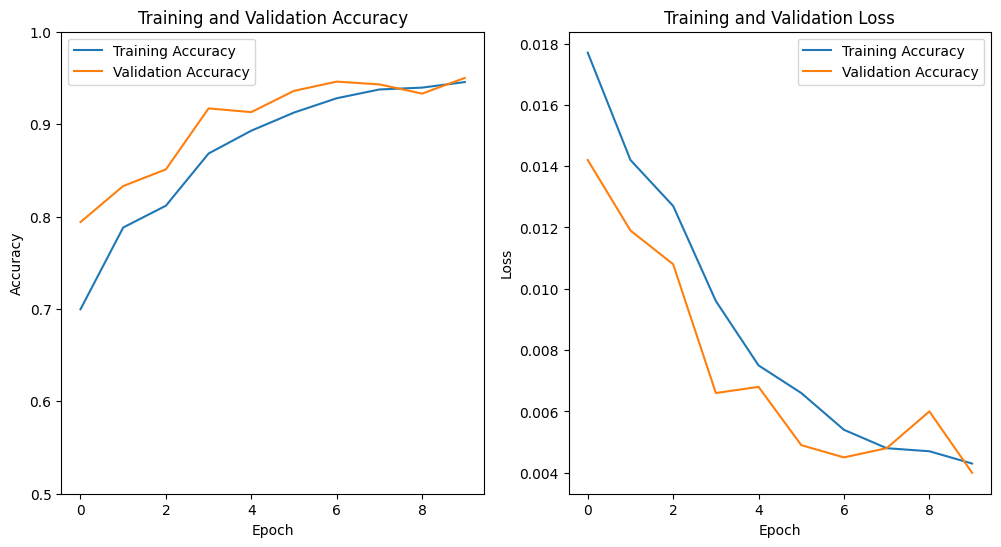

                   model    device  time_elapsed  best_epoch  best_acc
0  googlenet_5k_best.pth  Tesla T4    396.463814           9      0.95


In [24]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## GoogleNet Pre-Trained with ImageNet Dataset

In [25]:
model, model_name = googlenet_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [26]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0075 Acc: 0.8997
test Loss: 0.0035 Acc: 0.9620
✅ Best model saved! (Accuracy: 0.962)

Epoch 1/9
----------
train Loss: 0.0033 Acc: 0.9602
test Loss: 0.0030 Acc: 0.9710
✅ Best model saved! (Accuracy: 0.971)

Epoch 2/9
----------
train Loss: 0.0023 Acc: 0.9742
test Loss: 0.0030 Acc: 0.9600

Epoch 3/9
----------
train Loss: 0.0015 Acc: 0.9847
test Loss: 0.0026 Acc: 0.9760
✅ Best model saved! (Accuracy: 0.976)

Epoch 4/9
----------
train Loss: 0.0011 Acc: 0.9877
test Loss: 0.0025 Acc: 0.9660

Epoch 5/9
----------
train Loss: 0.0012 Acc: 0.9872
test Loss: 0.0024 Acc: 0.9740

Epoch 6/9
----------
train Loss: 0.0008 Acc: 0.9910
test Loss: 0.0026 Acc: 0.9700

Epoch 7/9
----------
train Loss: 0.0006 Acc: 0.9945
test Loss: 0.0025 Acc: 0.9730

Epoch 8/9
----------
train Loss: 0.0007 Acc: 0.9927
test Loss: 0.0029 Acc: 0.9690

Epoch 9/9
----------
train Loss: 0.0006 Acc: 0.9945
test Loss: 0.0023 Acc: 0.9690

Training complete in 6m 26s
Best test Acc: 0.976000


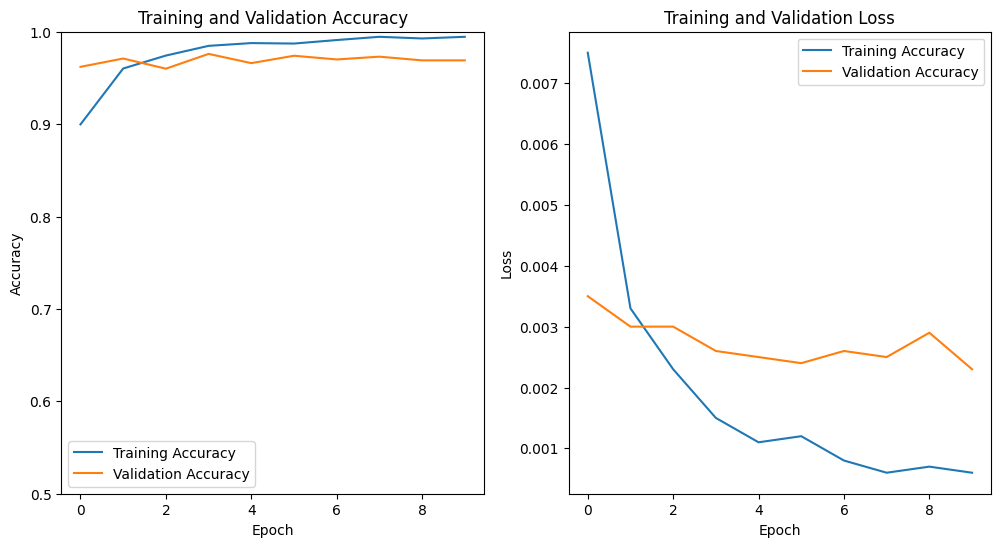

                      model    device  time_elapsed  best_epoch  best_acc
0  googlenet_pt_5k_best.pth  Tesla T4     386.21261           3     0.976


In [27]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ResNet18 Default Weights (without Freeze Layer)

In [28]:
model, model_name = resnet18(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [29]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0185 Acc: 0.6838
test Loss: 0.0136 Acc: 0.7950
✅ Best model saved! (Accuracy: 0.795)

Epoch 1/9
----------
train Loss: 0.0131 Acc: 0.7946
test Loss: 0.0110 Acc: 0.8400
✅ Best model saved! (Accuracy: 0.84)

Epoch 2/9
----------
train Loss: 0.0095 Acc: 0.8657
test Loss: 0.0084 Acc: 0.8930
✅ Best model saved! (Accuracy: 0.893)

Epoch 3/9
----------
train Loss: 0.0069 Acc: 0.9085
test Loss: 0.0052 Acc: 0.9340
✅ Best model saved! (Accuracy: 0.934)

Epoch 4/9
----------
train Loss: 0.0061 Acc: 0.9177
test Loss: 0.0060 Acc: 0.9250

Epoch 5/9
----------
train Loss: 0.0053 Acc: 0.9297
test Loss: 0.0050 Acc: 0.9360
✅ Best model saved! (Accuracy: 0.936)

Epoch 6/9
----------
train Loss: 0.0046 Acc: 0.9380
test Loss: 0.0048 Acc: 0.9420
✅ Best model saved! (Accuracy: 0.942)

Epoch 7/9
----------
train Loss: 0.0039 Acc: 0.9500
test Loss: 0.0075 Acc: 0.9040

Epoch 8/9
----------
train Loss: 0.0035 Acc: 0.9530
test Loss: 0.0036 Acc: 0.9520
✅ Best model saved! (Accura

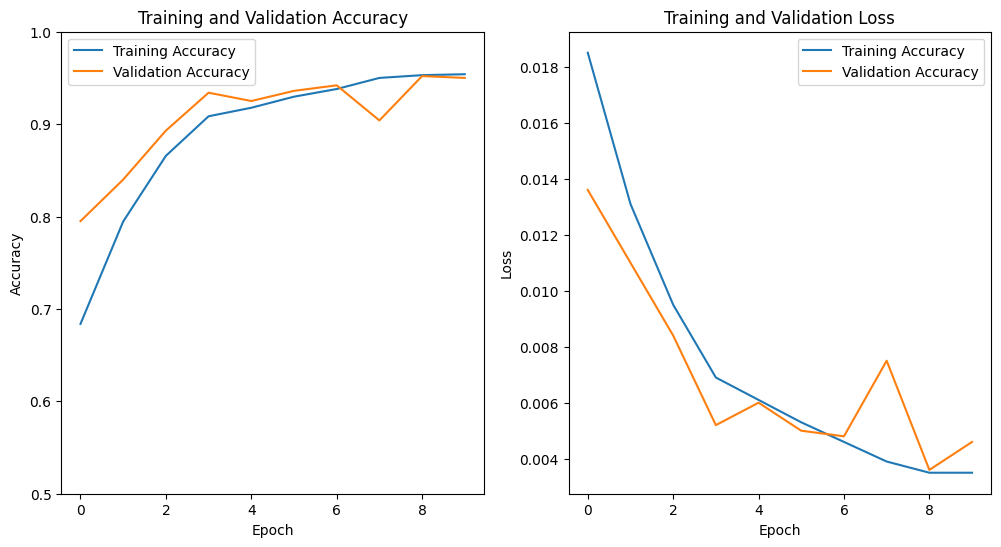

                  model    device  time_elapsed  best_epoch  best_acc
0  resnet18_5k_best.pth  Tesla T4    359.794058           8     0.952


In [30]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ResNet18 Pre-Trained with ImageNet Dataset

In [31]:
model, model_name = resnet18_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [32]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0062 Acc: 0.9175
test Loss: 0.0045 Acc: 0.9450
✅ Best model saved! (Accuracy: 0.945)

Epoch 1/9
----------


KeyboardInterrupt: 

In [ ]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## Vgg16 Default Weights (without Freeze Layer)

In [ ]:
model, model_name = vgg16(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

In [ ]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ## Vgg16 Pre-Trained with ImageNet dataset

In [ ]:
model, model_name = vgg16_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, 10)

In [ ]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)